In [1]:
import os
import numpy as np
import yaml
import pprint
import pickle
import utils.signals.gps_l1ca as gps_l1ca
import utils.sample_processing.sample_streaming as sample_streaming
import utils.sample_processing.bpsk_acquisition as bpsk_acquisition
import utils.sample_processing.tracking_kf2 as tracking_kf
import utils

from scipy.constants import speed_of_light

import matplotlib.pyplot as plt

In [2]:
# Get local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)
raw_collects_dir = os.path.join(data_dir, "raw-collects")
os.makedirs(raw_collects_dir, exist_ok=True)
raw_collect_filenames = sorted(os.listdir(raw_collects_dir))
print(f"Data directory: {data_dir}")
collect_metadata_filepath = os.path.join(raw_collects_dir, "metadata.yml")
with open(collect_metadata_filepath, "r") as f:
    collect_metadata = yaml.safe_load(f)
# pprint.pprint(collect_metadata)
collect_filepaths = {
    collect_id: os.path.join(raw_collects_dir, collect_info["filename"])
    for collect_id, collect_info in collect_metadata["collections"].items()
}

samp_rate = collect_metadata["samp_rate"]
inter_freq_l1_hz = collect_metadata["bands"]["L1"]["inter_freq"]
sample_params_dict = collect_metadata["sample_params"]
sample_params = sample_streaming.SampleParameters.from_dict(sample_params_dict)
print(f"Sample rate: {samp_rate/1e6} MHz")
# pprint.pprint(sample_params_dict)
pprint.pprint(sample_params)

collect_id_list = sorted(collect_filepaths.keys())
print("Available collects:")
for collect_id in collect_id_list:
    print(f"  {collect_id}: {os.path.basename(collect_filepaths[collect_id])}")

collect_id = collect_id_list[0]
collect_filepath = collect_filepaths[collect_id]
print(f"Using collect ID: {collect_id}")
# print(f"  Filepath: {collect_filepath}")

Data directory: /home/brianbw/projects/fall-2025-lectures/local-data
Sample rate: 25.0 MHz
SampleParameters(bit_depth=4,
                 is_complex=True,
                 is_integer=True,
                 is_signed=True,
                 is_i_lsb=True)
Available collects:
  20220513_173218_USRP2: CO_A2_20220513_173218_000211_G1_B1_USRP2.sc4
Using collect ID: 20220513_173218_USRP2


In [3]:
# Load acquisition results from file
acq_results_directory = os.path.join(data_dir, "acquisition-results")
os.makedirs(acq_results_directory, exist_ok=True)
acq_results_version_id = "v1"
acq_results_filepath = os.path.join(
    acq_results_directory, f"{collect_id}.{acq_results_version_id}.pkl"
)
with open(acq_results_filepath, "rb") as f:
    acq_results: dict[str, bpsk_acquisition.AcquisitionResult] = pickle.load(f)

acquired_signal_ids = sorted(list(filter(
    lambda sig_id: acq_results[sig_id].signal_detected, acq_results.keys()
)))
print(f"Acquired signals in collect {collect_id}: ")
print(", ".join(acquired_signal_ids))

Acquired signals in collect 20220513_173218_USRP2: 
G01, G02, G03, G06, G11, G12, G13, G14, G17, G19, G24, G28, G30


In [4]:
buffer_duration_ms = 40
block_duration_ms = 1
buffer_size_samples = int(samp_rate * buffer_duration_ms / 1e3)
block_size_samples = int(samp_rate * block_duration_ms / 1e3)

# duration_to_track_ms = 30000
duration_to_track_ms = 2000
num_blocks_to_track = duration_to_track_ms // block_duration_ms

# tracking_signal_ids = acquired_signal_ids
tracking_signal_ids = ["G17", "G21", "G30"]

root2pi = np.sqrt(2.0 * np.pi)
tracking_signal_states = {
    sig_id: tracking_kf.KFSignalState(
        0.0,  # TODO: set proper acquisition epoch uptime
        code_phase_seconds=acq_results[sig_id].acq_code_phase_seconds,
        carrier_phase_rad=0.0,
        doppler_rad_per_sec=acq_results[sig_id].acq_doppler_hz * 2.0 * np.pi,
        # accel_rad_per_sec2=0.0,
        # initial_code_phase_uncertainty=1e-6,  # about 300 m
        initial_code_phase_uncertainty=1e-9,
        initial_carrier_phase_uncertainty=root2pi / 2,  # ~ 90 degrees
        initial_doppler_uncertainty=10.0 * root2pi,  # 100 Hz
        # initial_accel_uncertainty=1e-4 * root2pi,  # 1 Hz/s
    )
    for sig_id in tracking_signal_ids
}
GPS_L1_tracking_signal_params = {
    "G{:02d}".format(prn): tracking_kf.TrackingSignalParameters(
        code_seq=1 - 2 * gps_l1ca.get_GPS_L1CA_code_sequence(prn),
        nominal_code_rate_chips_per_sec=gps_l1ca.CODE_RATE,
        carrier_freq_hz=gps_l1ca.CARRIER_FREQ,
    ) for prn in range(1, 33)
}
# Track for 60 seconds of output
tracking_outputs = {
    sig_id: tracking_kf.SignalTrackingOutputs(num_blocks_to_track)
    for sig_id in tracking_signal_ids
}
# Use same tracking loop parameters for all signals
tracking_loop_params = tracking_kf.KFLoopParameters(
    update_period_ms=block_duration_ms,
    integration_period_ms=block_duration_ms,
    carrier_freq_hz=gps_l1ca.CARRIER_FREQ,
    q_eta=1e-15,
    q_b=5e-22,
    q_d=4e-19,
    q_a=1e-20,
    samp_rate=samp_rate,
    nominal_cn0_dbhz=45.0,
    EPL_chip_spacing=0.5
)

In [5]:
tracking_loop_params.R[0, 0] = 1e-6**2

In [6]:
# h_0 = 6.4e-26
# h_m2 = 4.3e-23

# h_0 = 1e-21
# h_m2 = 2e-20
# q_b = h_0 / 2
# q_d = 2 * np.pi**2 * h_m2
# print(q_b, q_d)

In [7]:
with sample_streaming.FileSampleStream(
        collect_filepath,
        sample_params,
        buffer_size_samples,
        block_size_samples,
    ) as sample_stream:

    sample_block_generator = sample_stream.sample_block_generator()
    
    for i_block, sample_block in enumerate(sample_block_generator):
        if i_block >= num_blocks_to_track:
            break
        print(f"\r Processing block {i_block}...", end="")

        uptime_seconds = i_block * block_duration_ms * 1e-3
        
        # Mixdown to baseband
        phi_IF = 2 * np.pi * inter_freq_l1_hz * (uptime_seconds + tracking_loop_params.block_sample_time_arr)
        sample_block *= np.exp(-1j * phi_IF)

        # Track each signal
        for sig_id, signal_state in tracking_signal_states.items():
            signal_params = GPS_L1_tracking_signal_params[sig_id]
            signal_outputs = tracking_outputs[sig_id]
            tracking_kf.track_signal(
                uptime_seconds,
                sample_block,
                signal_params,
                signal_state,
                tracking_loop_params,
                signal_outputs,
            )
        

 Processing block 1999...

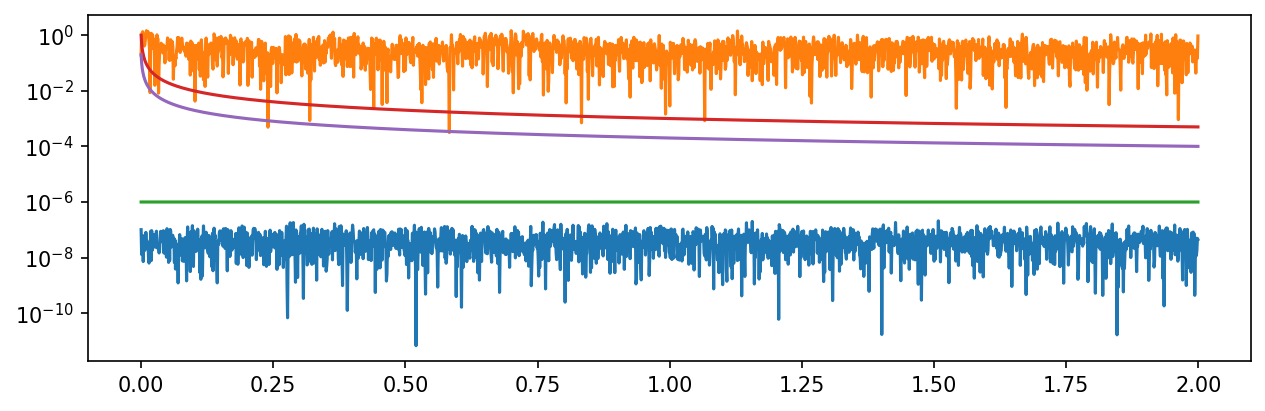

In [8]:
fig = plt.figure(figsize=(10, 3), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(signal_outputs.uptime_seconds, np.abs(signal_outputs.meas_vector[:, 0]))
ax.plot(signal_outputs.uptime_seconds, np.abs(signal_outputs.meas_vector[:, 1]))
ax.plot(signal_outputs.uptime_seconds, signal_outputs.kalman_gain[:, 0, 0])
ax.plot(signal_outputs.uptime_seconds, signal_outputs.kalman_gain[:, 1, 1])
ax.plot(signal_outputs.uptime_seconds, signal_outputs.kalman_gain[:, 2, 1])
ax.set_yscale("log")
plt.show()

In [9]:
q_eta=1e-12
q_b=5e-20
q_d=4e-19
q_a=1e-20
Q = tracking_kf.construct_Q_matrix(
    q_eta, q_b, q_d, q_a, gps_l1ca.CARRIER_FREQ * 2 * np.pi, tracking_loop_params.update_period_ms / 1e3
)
print(np.sqrt(np.diag(Q)))

[3.16227774e-08 6.99941597e-02 1.97973116e-01]


In [10]:
np.sqrt(np.diag(tracking_loop_params.Q))

array([1.00000025e-09, 7.00033983e-03, 1.97973116e-01])

In [11]:
# Save tracking results from file
tracking_results_directory = os.path.join(data_dir, "tracking-results")
os.makedirs(tracking_results_directory, exist_ok=True)
tracking_results_version_id = "vK_1"
tracking_results_filepath = os.path.join(
    tracking_results_directory, f"{collect_id}.{tracking_results_version_id}.pkl"
)
with open(tracking_results_filepath, "wb") as f:
    pickle.dump(tracking_loop_params, f)
    pickle.dump(tracking_outputs, f)

In [12]:
signal_outputs.doppler_freq_hz

array([-3503.04708672, -3520.442357  , -3538.85134513, ...,
       -3584.66932702, -3586.99086704, -3601.73940319], shape=(2000,))

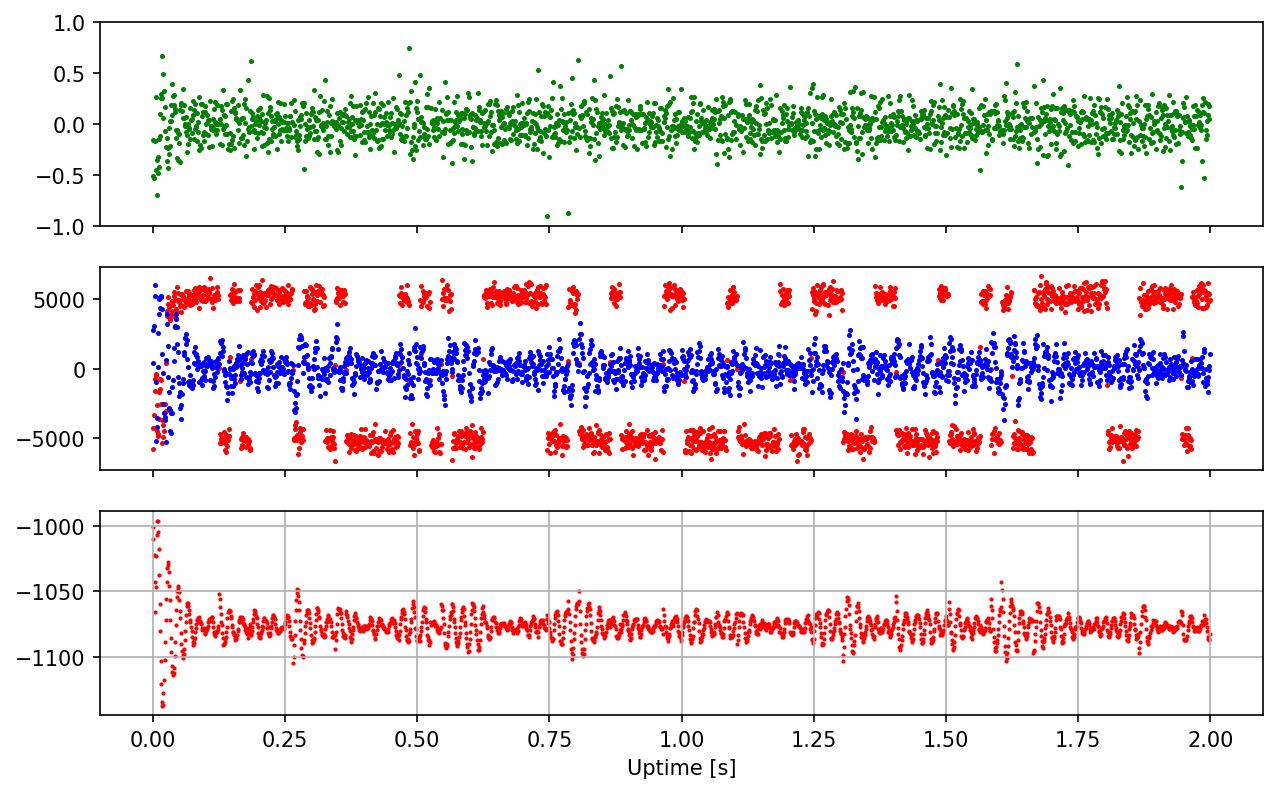

In [13]:
# sig_id = tracking_signal_ids[0]
sig_id = "G17"
signal_outputs = tracking_outputs[sig_id]
fig = plt.figure(figsize=(10, 6), dpi=150)
axes = fig.subplots(3, 1, sharex=True)
prompt = signal_outputs.prompt_corr
# ax.scatter(signal_outputs.uptime_seconds, prompt.real, s=2, color="r")
# ax.scatter(signal_outputs.uptime_seconds, prompt.imag, s=2, color="b")

# prompt = signal_outputs.prompt_corr * np.exp(-1j * 2.0 * np.pi * 530 * signal_outputs.uptime_seconds)
# ax.scatter(signal_outputs.uptime_seconds, prompt.real, s=2, color="r")
# ax.scatter(signal_outputs.uptime_seconds, prompt.imag, s=2, color="b")

prompt = signal_outputs.prompt_corr
delta_phase = np.angle(prompt[1:] / prompt[:-1])
ax = axes[0]
ax.scatter(signal_outputs.uptime_seconds[:-1], delta_phase, s=2, color="g")
ax.set_ylim(-1, 1)

ax = axes[1]
ax.scatter(signal_outputs.uptime_seconds, prompt.real, s=2, color="r")
ax.scatter(signal_outputs.uptime_seconds, prompt.imag, s=2, color="b")


ax = axes[2]
ax.scatter(signal_outputs.uptime_seconds, signal_outputs.doppler_freq_hz, s=1, color="r")
# mean_delta_phase = np.mean(delta_phase)
# print(f"Mean delta phase: {mean_delta_phase} rad")
ax.grid()
ax.set_xlabel("Uptime [s]")
plt.show()

In [14]:
1 / (2 * np.pi) / .001

159.15494309189535

In [15]:
-.5 / (2 * np.pi) / .001

-79.57747154594767

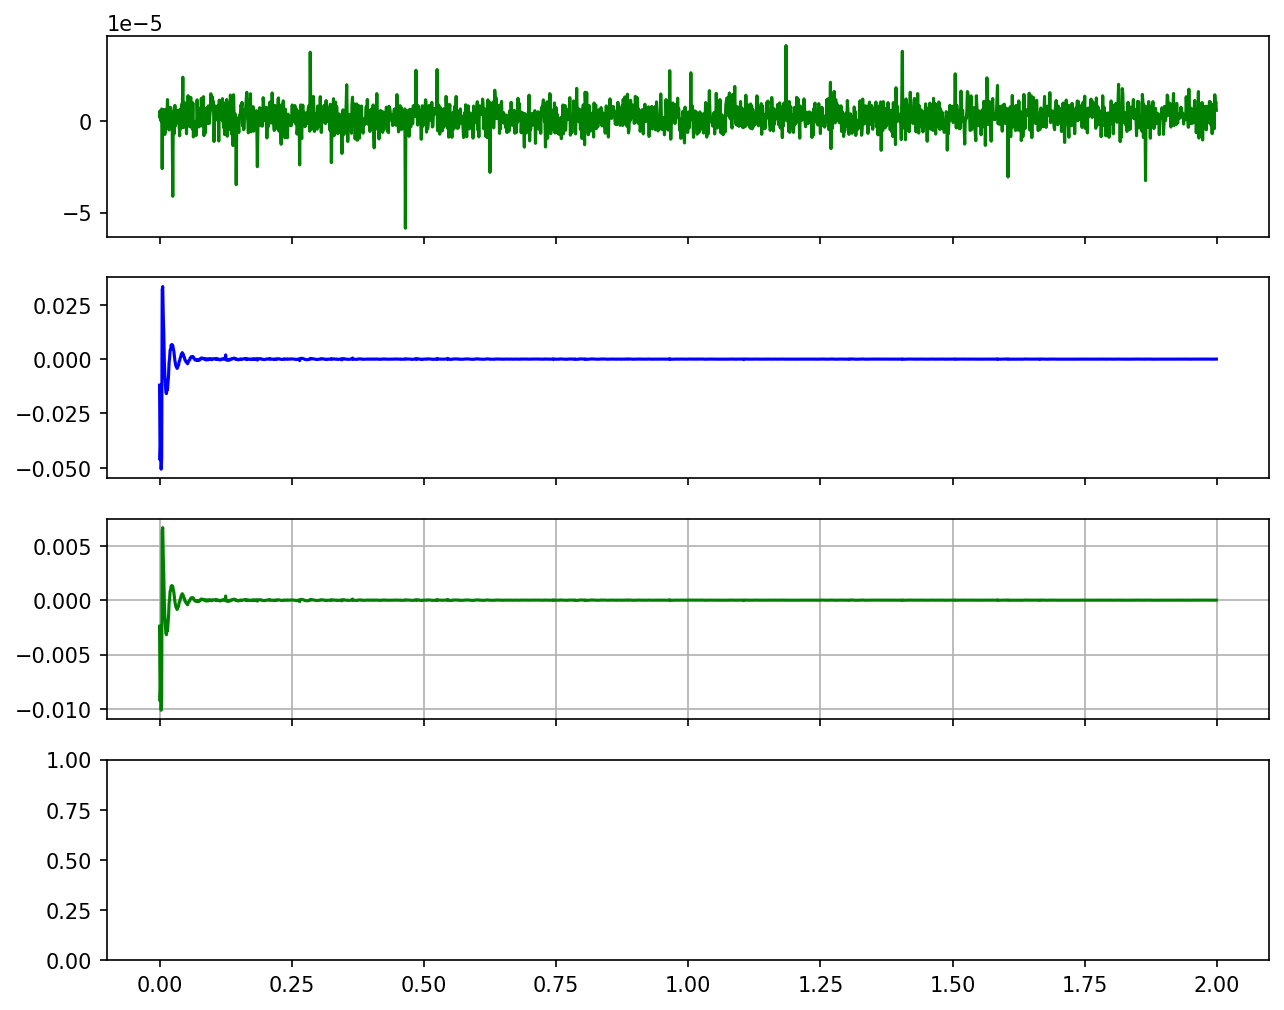

In [16]:
fig = plt.figure(figsize=(10, 8), dpi=150)
axes = fig.subplots(4, 1, sharex=True)

ax = axes[0]
code_state_delta_meters = signal_outputs.state_delta[:, 0] * speed_of_light
code_state_uncertainty_meters = signal_outputs.code_phase_uncertainty_seconds * speed_of_light
ax.plot(signal_outputs.uptime_seconds, code_state_delta_meters, color="g")
# ax.plot(signal_outputs.uptime_seconds, code_state_uncertainty_meters, color="r", linestyle="--")

ax = axes[1]
carr_state_delta_cycles = signal_outputs.state_delta[:, 1] / (2.0 * np.pi)
carr_state_uncertainty_cycles = signal_outputs.carr_phase_uncertainty_cycles
ax.plot(signal_outputs.uptime_seconds, carr_state_delta_cycles, color="b")
# ax.plot(signal_outputs.uptime_seconds, carr_state_uncertainty_cycles, color="r", linestyle="--")

ax = axes[2]
doppler_state_delta_hz = signal_outputs.state_delta[:, 2] / (2.0 * np.pi)
doppler_state_uncertainty_hz = signal_outputs.doppler_uncertainty_hz
ax.plot(signal_outputs.uptime_seconds, doppler_state_delta_hz, color="g")
# ax.plot(signal_outputs.uptime_seconds, doppler_state_uncertainty_hz, color="r", linestyle="--")

# ax = axes[3]
# accel_state_delta_hzps = signal_outputs.state_delta[:, 3] / (2.0 * np.pi)
# accel_state_uncertainty_hzps = signal_outputs.accel_uncertainty_rad_per_sec2 / (2.0 * np.pi)
# ax.plot(signal_outputs.uptime_seconds, accel_state_delta_hzps, color="m")
# # ax.plot(signal_outputs.uptime_seconds, accel_state_uncertainty_hzps, color="r", linestyle="--")
# ax.set_xlim(0, .1)
ax.grid()
plt.show()

In [17]:
from kf_dynamics import compute_3rd_order_steady_state_kalman_gain

In [18]:
loop_bw = 50.0  # Hz
compute_3rd_order_steady_state_kalman_gain(
    ti=1e-3,
    omega_n =.7845 / loop_bw,
    a_n=1.1,
    b_n=2.4
)

array([[3.76555938e-05],
       [2.70785985e-07],
       [3.86250301e-09]])

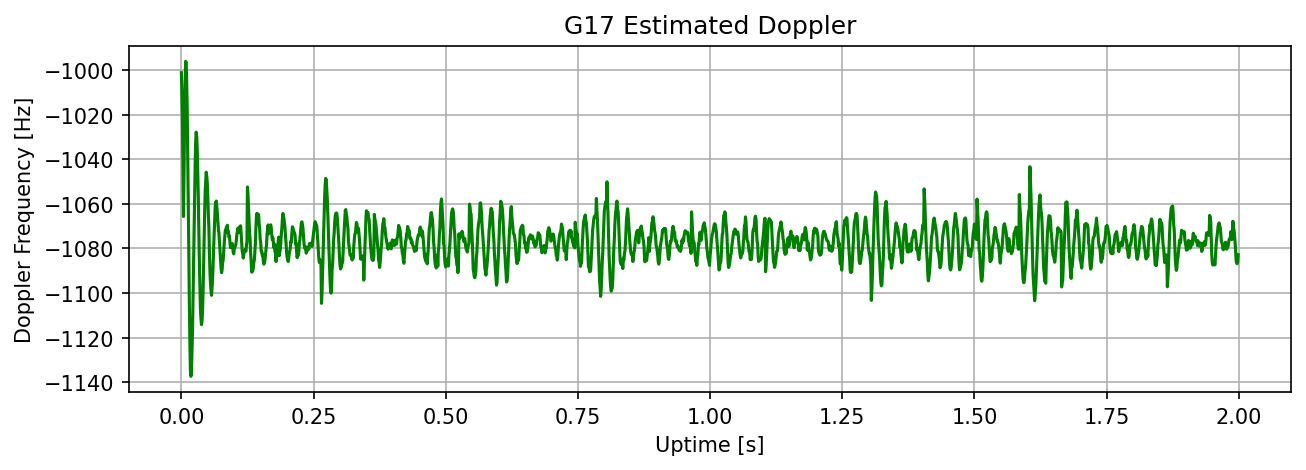

In [19]:
fig = plt.figure(figsize=(10, 3), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    signal_outputs.uptime_seconds, signal_outputs.doppler_freq_hz, color="g"
)
# ax.plot(
#     signal_outputs.uptime_seconds, signal_outputs.doppler_uncertainty_hz, color="r", linestyle="--"
# )
ax.grid()
ax.set_title(f"{sig_id} Estimated Doppler")
ax.set_xlabel("Uptime [s]")
ax.set_ylabel("Doppler Frequency [Hz]")
plt.show()

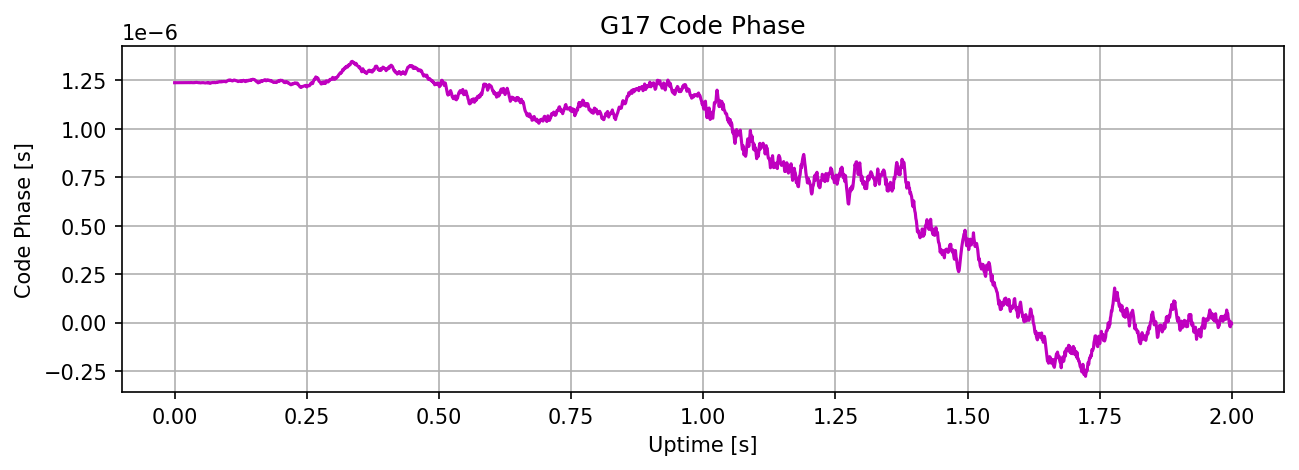

In [20]:
fig = plt.figure(figsize=(10, 3), dpi=150)
ax = fig.add_subplot(1, 1, 1)
code_delay_seconds = signal_outputs.uptime_seconds - signal_outputs.code_phase_seconds
code_delay_meters = code_delay_seconds * speed_of_light
adr_meters = -signal_outputs.carr_phase_cycles * (
    speed_of_light / gps_l1ca.CARRIER_FREQ
)
code_minus_carr_meters = code_delay_meters - adr_meters
code_minus_carr_meters -= np.mean(code_minus_carr_meters[-100:])
# ax.plot(signal_outputs.uptime_seconds, code_delay_seconds, color="m")  # convert to ms
ax.plot(signal_outputs.uptime_seconds, code_minus_carr_meters, color="m")  # convert to ms
ax.grid()
ax.set_title(f"{sig_id} Code Phase")
ax.set_xlabel("Uptime [s]")
ax.set_ylabel("Code Phase [s]")
plt.show()

Text(0.5, 1.0, 'Arctan Discriminator Noise Variance vs. SNR')

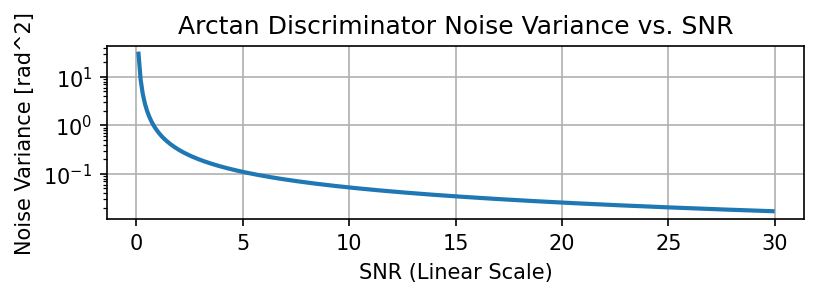

In [21]:
import numpy as np
import matplotlib.pyplot as plt

snr = np.arange(0.1, 30, 0.1)
noise_var = 1 / (2 * snr) * (1 + 1 / (2 * snr))

fig = plt.figure(figsize=(6, 1.5), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(snr, noise_var, linewidth=2)
ax.set_xlabel("SNR (Linear Scale)")
ax.set_ylabel("Noise Variance [rad^2]")
ax.set_yscale("log")
ax.grid()
ax.set_title("Arctan Discriminator Noise Variance vs. SNR")